In [1]:
using ConvDiff
using PyPlot
using jInv.Mesh
using jInv.ForwardShare
using jInv.InverseSolve
using jInvVis
using jInv.LinearSolvers
using MAT

In [37]:
# filename= "2DmodelLShaped.mat"
filename= "Peaks2D.mat"
file = matread(filename)
# problem description
domain = file["domain"]
v      = file["v"]
sig    = file["sig"]

# data and receiver location
dtrue   = file["dtrue"]
rec    = file["rec"];


# Setup Forward Problem

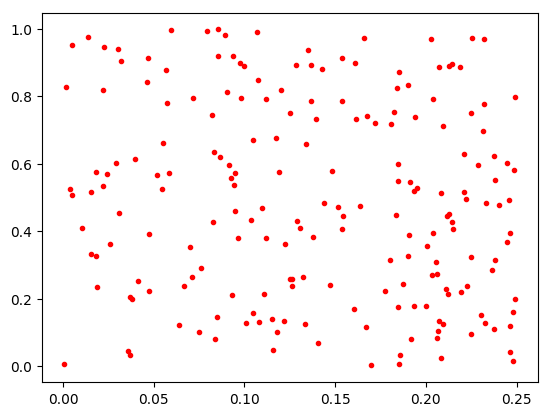

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12d2deb90>

In [43]:
domain[2] = 1
rec[:,1]/=2
M = getRegularMesh(domain,[128 128]);

# build linear interpolation matrix from nodes to receiver locations
x1,x2 = getCellCenteredAxes(M)
P = interpmat(x1,x2, rec);

vc = ones(prod(M.n+2))*v'
dobs = dtrue + 0.01*randn(size(dtrue))

pFor = getConvDiffParam(M,vc,sig=sig,P=P,Ainv=getMUMPSsolver());

plot(rec[:,1],rec[:,2],".r")


# Setup Inverse Problem

In [39]:
alpha      = 1e-2
mref       = zeros(M.nc)           
Wt         = ones(size(dobs))      
sigback    = 0.0
pMis       = getMisfitParam(pFor,Wt,dobs,SSDFun) 
	
## Configure regularization
# reg        = (m,mr,M,I=1.0) -> anisoTVReg(m,mr,M,eps=1e-8)  
reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  
	
## Configure optimization
HesPrec    = getSSORRegularizationPreconditioner(1.0,1e-15,50)
cgit       = 5 
pcgTol     = 1e-1
maxIter    = 1000
minUpdate  = 1e-3
	
## Solve the continuous relaxation of the inverse problem
modFun     = identityMod
boundsLow  = 0*ones(M.nc)
boundsHigh = 1*ones(M.nc)
maxStep	   = 0.1*maximum(boundsHigh)
pInv       = getInverseParam(M,modFun,reg,alpha,mref,
                             boundsLow,boundsHigh,maxStep=maxStep,
                            pcgMaxIter=cgit,pcgTol=pcgTol,minUpdate=minUpdate,maxIter=maxIter,
                            HesPrec=HesPrec);
	


# Run Inversion

In [40]:

mc,Dc,flag,His = projGNCG(mref+0.1,pInv,pMis)
uc = pFor.Fields;          # u variables
wr = pInv.modelfun(mc)[1]; # w variables



 i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	9.38e-01	2.82e-03	1.00e-02	1.00e+00	  0
   .1	8.55e-01	3.22e-03			9.12e-01
  2.0	8.55e-01	3.22e-03	1.00e-02	9.12e-01	  1
   .1	5.71e-01	4.69e-03			6.12e-01
  3.0	5.71e-01	4.69e-03	1.00e-02	6.12e-01	  0
   .1	4.24e-01	5.93e-03			4.57e-01
  4.0	4.24e-01	5.93e-03	1.00e-02	4.57e-01	  0
   .1	3.29e-01	7.14e-03			3.57e-01
  5.0	3.29e-01	7.14e-03	1.00e-02	3.57e-01	  0
   .1	2.55e-01	8.42e-03			2.80e-01
  6.0	2.55e-01	8.42e-03	1.00e-02	2.80e-01	  0
   .1	2.00e-01	9.61e-03			2.23e-01
  7.0	2.00e-01	9.61e-03	1.00e-02	2.23e-01	  0
   .1	1.60e-01	1.07e-02			1.81e-01
  8.0	1.60e-01	1.07e-02	1.00e-02	1.81e-01	  0
   .1	1.27e-01	1.18e-02			1.48e-01
  9.0	1.27e-01	1.18e-02	1.00e-02	1.48e-01	  0
   .1	1.01e-01	1.29e-02			1.21e-01
 10.0	1.01e-01	1.29e-02	1.00e-02	1.21e-01	  0
   .1	7.91e-02	1.39e-02			9.89e-02
 11.0	7.91e-02	1.39e-02	1.00e-02	9.89e-02	  0
   .1	6.15e-02	1.49e-02			8.12e-02
 12.0	6.15e-02	1.49e-02	1.00e-02	8.12e-02	270
   .1	4.91e

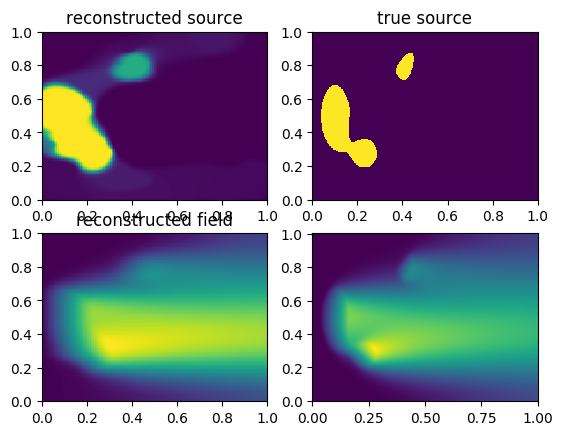

PyObject <matplotlib.collections.QuadMesh object at 0x12ec2eb10>

In [41]:
subplot(2,2,1)
viewImage2D(wr,M)
title("reconstructed source")
subplot(2,2,2)
viewImage2D(vec(file["W"]),getRegularMesh(domain,file["m"]));
title("true source")

subplot(2,2,3)
viewImage2D(uc,M)
title("reconstructed field")

subplot(2,2,4)
viewImage2D(vec(file["utrue"]),getPaddedMesh(getRegularMesh(domain,file["m"])))